# VSA Item Memories

This notebook investigates the different ways to make the item memories. We explore different versions and data types and characterize each uniquely.

In [1]:
# Import library
import os
import sys
import numpy as np

# Gets directory where script was launched from
script_dir = os.getcwd()  
script_dir = script_dir + "/../lib/"
print(f"VSA Library: {script_dir}")

# Add the directory to Python's search path
sys.path.append(script_dir)  

import vsa as vsa
import vsa_func as vsaf
import vsa_profile as vsap

VSA Library: \\wsl.localhost\Ubuntu\home\rantonio\chronomatica\vsa/../lib/


# General Orthogonal Item Memories
- Orthogonal item memories need to make sure that every hypervector (HV) generated is pseudo-orthogonal to the block.
- Naturally, if we just use `rand` function in Python is sufficient.
- Let's investigate how the confusion matrices look like per data type.

In [2]:
# Parameters to modify
HV_DIM = 1000
NUM_IM_ITEMS = 100

In [3]:
def gen_im_blocks(num_items, hv_dim):
    # Generate IMs
    binary_im = vsaf.gen_orthogonal_im(num_items, hv_dim, type="binary")
    bipolar_im = vsaf.gen_orthogonal_im(num_items, hv_dim, type="bipolar")
    integer_im = vsaf.gen_orthogonal_im(num_items, hv_dim, type="integer", int_min=-128, int_max=127)
    real_im = vsaf.gen_orthogonal_im(num_items, hv_dim, type="real")
    
    return binary_im, bipolar_im, integer_im, real_im

binary_im, bipolar_im, integer_im, real_im = gen_im_blocks(NUM_IM_ITEMS, HV_DIM)

In [4]:
# Print 1st 10 element of a vector of each IM to visualize
print("Binary IM:")
print(binary_im[0][:10])
print("\nBipolar IM:")
print(bipolar_im[0][:10])
print("\nInteger IM:")
print(integer_im[0][:10])
print("\nReal IM:")
print(real_im[0][:10])

Binary IM:
[0. 1. 1. 0. 0. 0. 0. 0. 1. 1.]

Bipolar IM:
[ 1.  1. -1. -1. -1.  1.  1. -1.  1.  1.]

Integer IM:
[-97.  35.   1.  -1. -81. -98.  66.  85.  97. -89.]

Real IM:
[ 0.55097078  0.82673856 -0.53735189 -0.98878307  0.08712268 -0.16427473
 -0.28881447  0.381705   -0.23877583 -0.51352528]


## Measure the Confusion Matrix
Now we check for the confusion matrices of each and see who has the best orthogonality.
- It is important to note that there are several similarity measurements.
- You would use Hamming distance for the binary case, but you would almost always use cosine for all the other data types.
- However, hamming is just the most efficient one if someone uses binary search.

In [5]:
def gen_im_confusion_matrices(binary_im, bipolar_im, integer_im, real_im):
    # Generate confusion matrices
    binary_im_conf = vsaf.gen_confusion_matrix(binary_im, vsa.hv_ham)
    bipolar_im_conf = vsaf.gen_confusion_matrix(bipolar_im, vsa.hv_cos)
    integer_im_conf = vsaf.gen_confusion_matrix(integer_im, vsa.hv_cos)
    real_im_conf = vsaf.gen_confusion_matrix(real_im, vsa.hv_cos)
    return binary_im_conf, bipolar_im_conf, integer_im_conf, real_im_conf

(binary_im_conf, 
 bipolar_im_conf, 
 integer_im_conf, 
 real_im_conf) = gen_im_confusion_matrices(
    binary_im, 
    bipolar_im, 
    integer_im, 
    real_im
)

## Plotting the confusion matrices

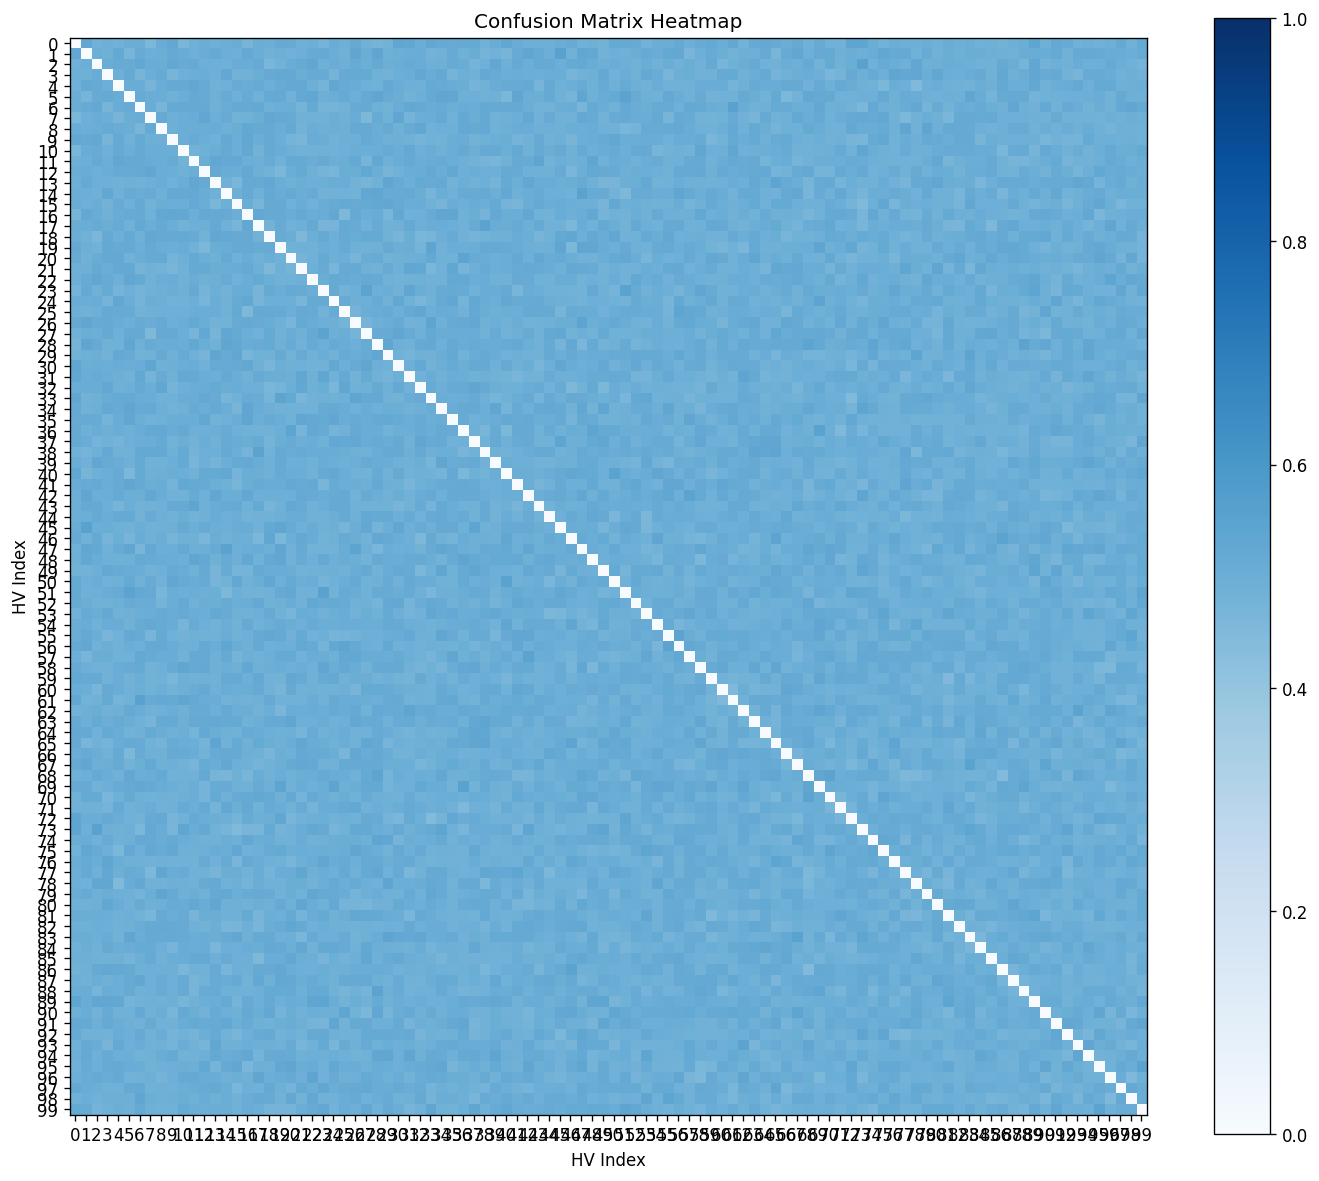

In [6]:
vsap.plot_confmap(binary_im_conf, figsize=(12, 10), dpi=120, vmin=0, vmax=1, decimals=3, annotations=False)

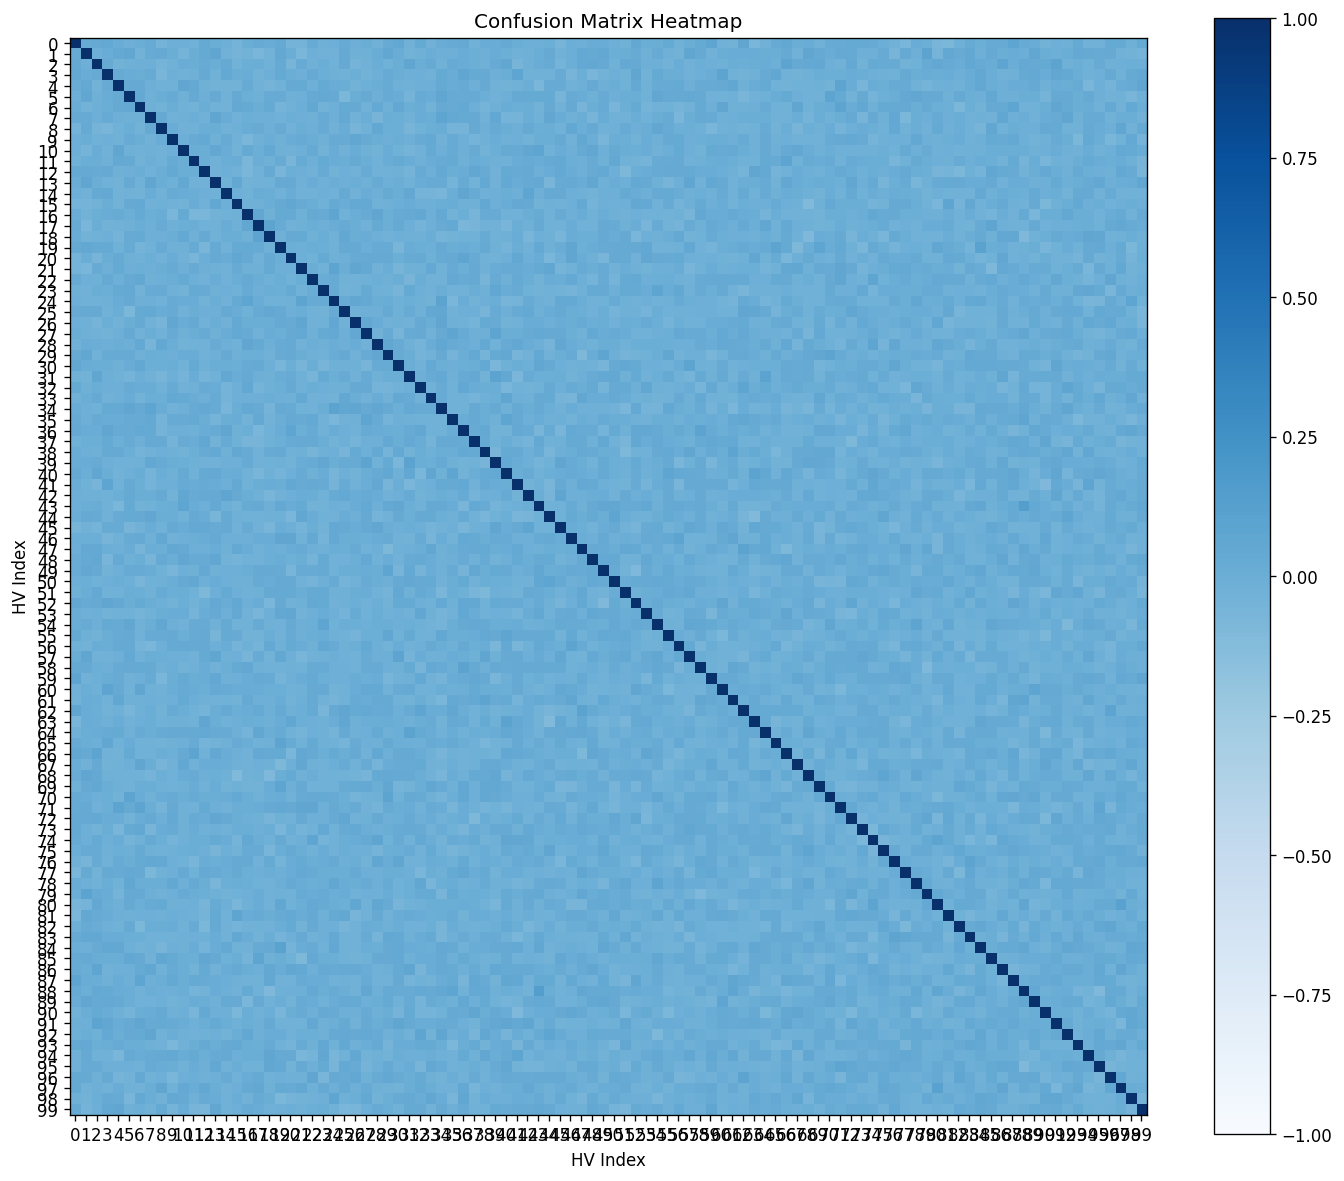

In [7]:
vsap.plot_confmap(bipolar_im_conf, figsize=(12, 10), dpi=120, vmin=-1, vmax=1, annotations=False)

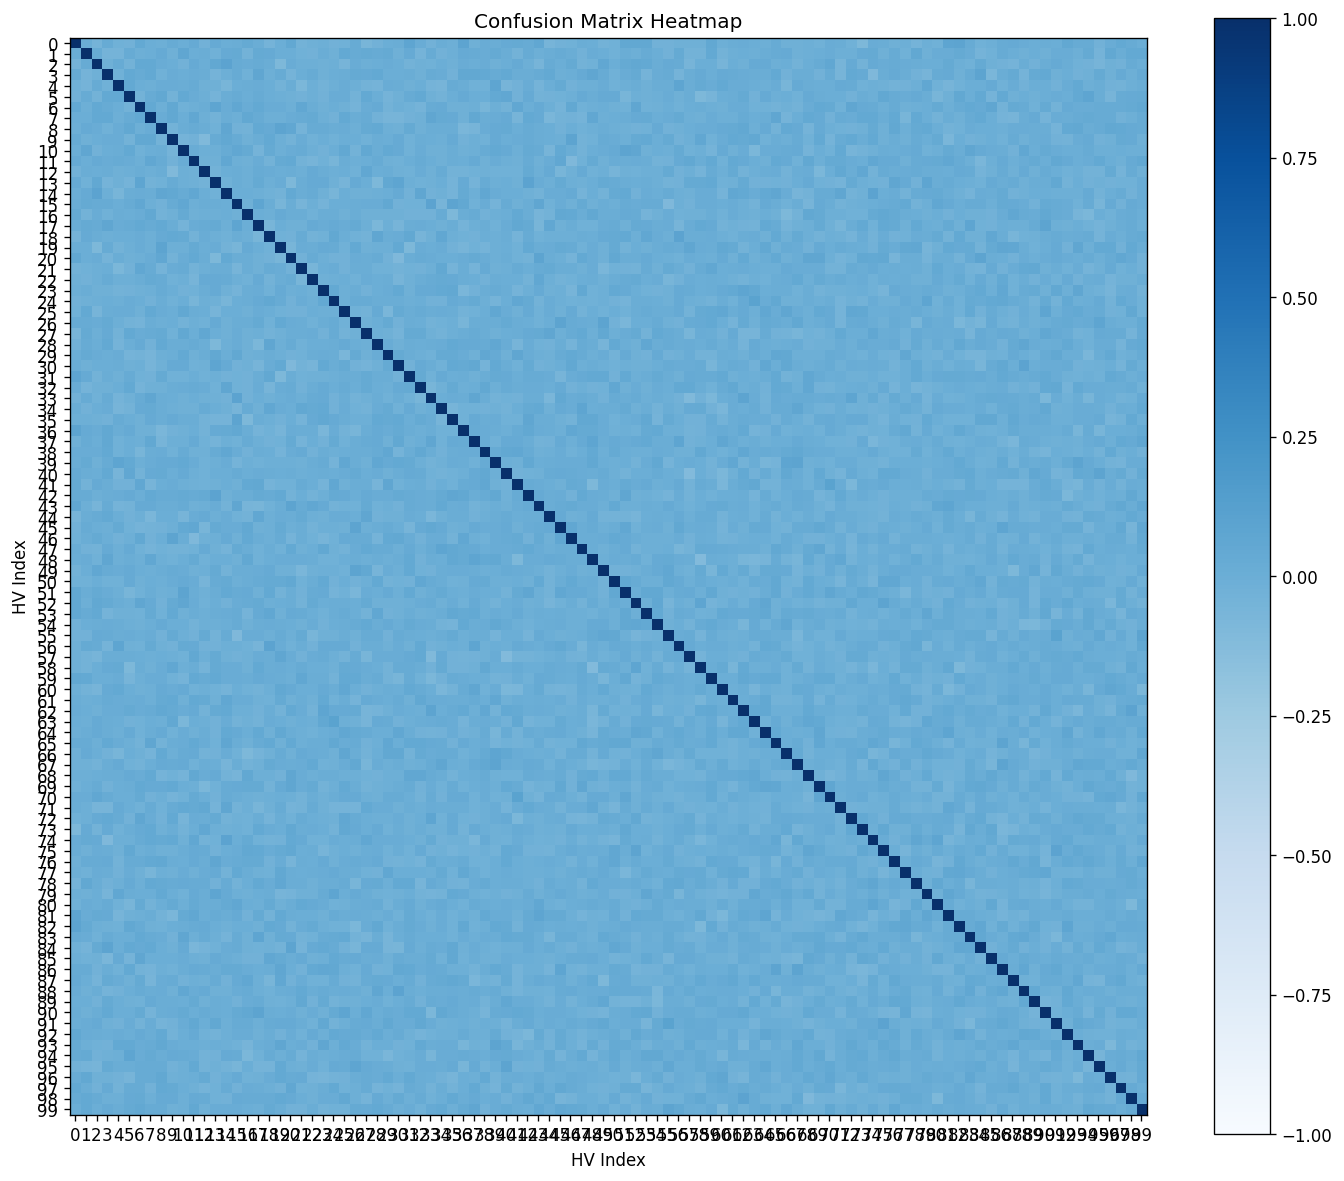

In [8]:
vsap.plot_confmap(integer_im_conf, figsize=(12, 10), dpi=120, vmin=-1, vmax=1, annotations=False)

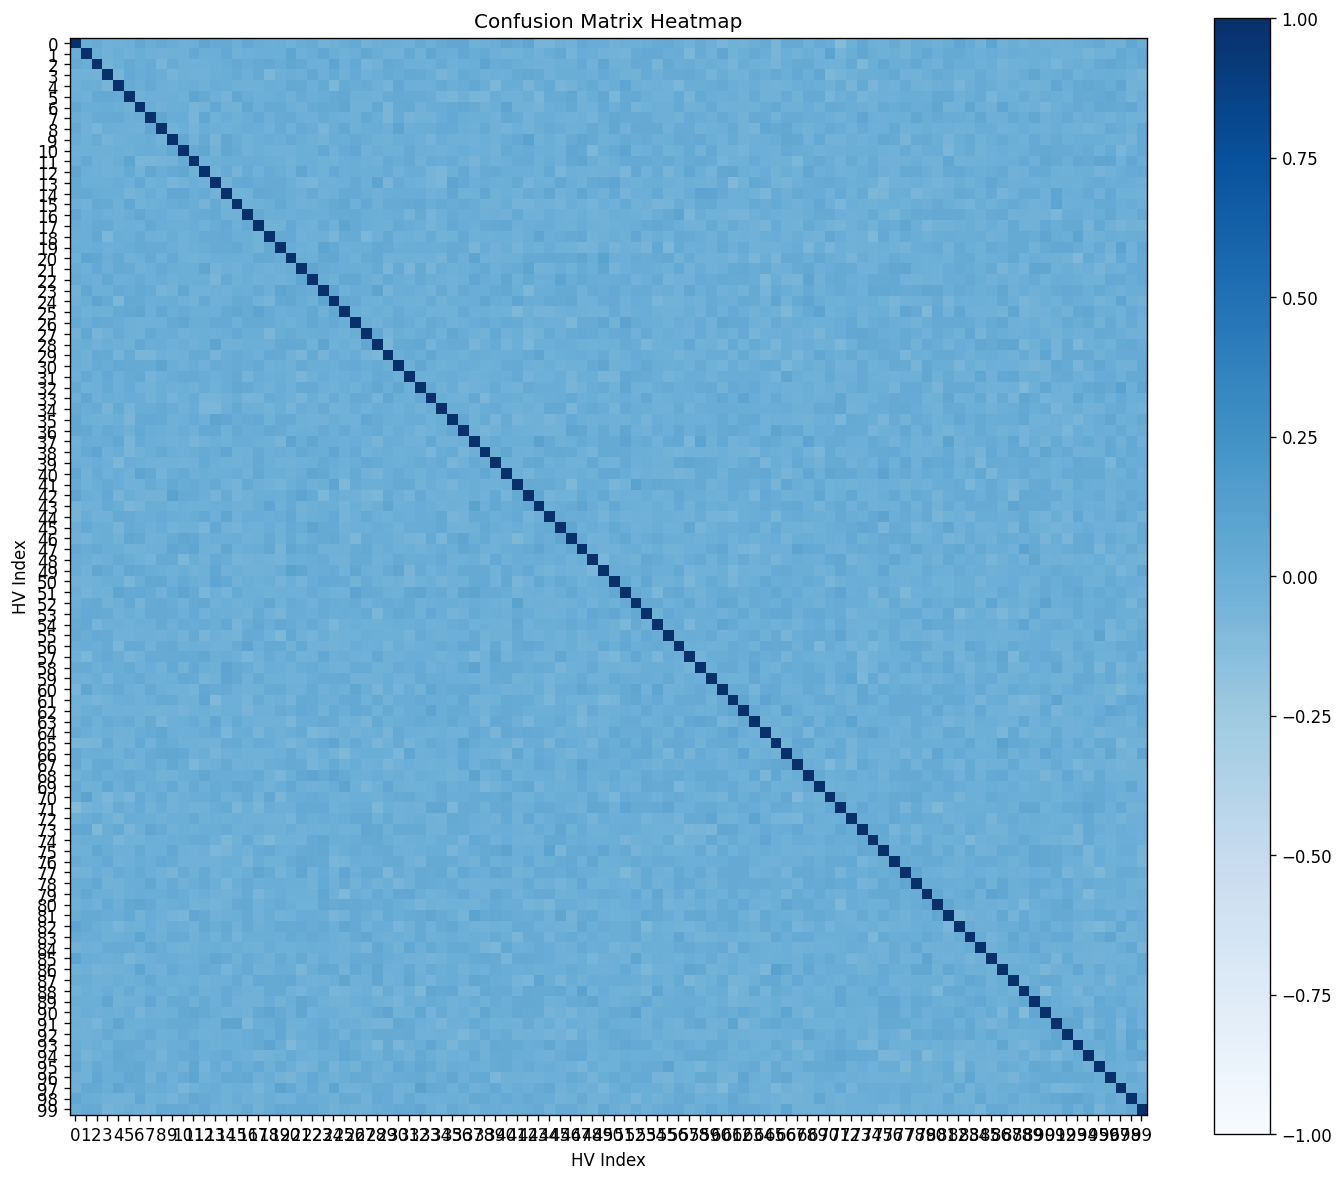

In [9]:
vsap.plot_confmap(real_im_conf, figsize=(12, 10), dpi=120, vmin=-1, vmax=1, annotations=False)

## Comparison of distrubtions
- Now we compare the distribution of each.
- First we normalize to $[0,1]$ range.

In [10]:
def gen_norm_im_confusion_matrices(binary_im_conf, bipolar_im_conf, integer_im_conf, real_im_conf):
    # Normalize confusion matrices
    norm_binary_im_conf = vsap.minmax_normalize(binary_im_conf, min_val=0, max_val=1)
    norm_bipolar_im_conf = vsap.minmax_normalize(bipolar_im_conf, min_val=-1, max_val=1)
    norm_integer_im_conf = vsap.minmax_normalize(integer_im_conf, min_val=-1, max_val=1)
    norm_real_im_conf = vsap.minmax_normalize(real_im_conf, min_val=-1, max_val=1)
    return norm_binary_im_conf, norm_bipolar_im_conf, norm_integer_im_conf, norm_real_im_conf

(norm_binary_im_conf, 
 norm_bipolar_im_conf, 
 norm_integer_im_conf, 
 norm_real_im_conf) = gen_norm_im_confusion_matrices(
     binary_im_conf, bipolar_im_conf, integer_im_conf, real_im_conf)

- Then we extract only the upper triangle of the matrix.
- But make sure to exclude the diagonal.

In [11]:
def gen_extract_upper_triangles(bipolar_im_conf, norm_bipolar_im_conf, norm_integer_im_conf, norm_real_im_conf, binary_im_conf):
    # Extract indices. They will be the same for all.
    i, j = np.triu_indices(bipolar_im_conf.shape[0], k=1)

    # Extract the components
    upper_binary_im_conf = binary_im_conf[i, j]
    upper_bipolar_binary_im_conf = norm_bipolar_im_conf[i, j]
    upper_integer_im_conf = norm_integer_im_conf[i, j]
    upper_real_im_conf = norm_real_im_conf[i, j]
    return upper_binary_im_conf, upper_bipolar_binary_im_conf, upper_integer_im_conf, upper_real_im_conf

(upper_binary_im_conf, 
 upper_bipolar_binary_im_conf, 
 upper_integer_im_conf, 
 upper_real_im_conf) = gen_extract_upper_triangles(
     bipolar_im_conf,
     norm_bipolar_im_conf, 
     norm_integer_im_conf, 
     norm_real_im_conf, 
     binary_im_conf
)


- Then we compute the mean and variance of the extracted values

In [12]:
def measure_mean_var(upper_binary_im_conf, upper_bipolar_binary_im_conf, upper_integer_im_conf, upper_real_im_conf):
    binary_mean, binary_var = vsap.measure_mean_var(upper_binary_im_conf)
    bipolar_mean, bipolar_var = vsap.measure_mean_var(upper_bipolar_binary_im_conf)
    integer_mean, integer_var = vsap.measure_mean_var(upper_integer_im_conf)
    real_mean, real_var = vsap.measure_mean_var(upper_real_im_conf)

    print(f"Binary IM: mean={binary_mean:.4f}, var={binary_var:.4f}")
    print(f"Bipolar IM: mean={bipolar_mean:.4f}, var={bipolar_var:.4f}")
    print(f"Integer IM: mean={integer_mean:.4f}, var={integer_var:.4f}")
    print(f"Real IM: mean={real_mean:.4f}, var={real_var:.4f}")

measure_mean_var(
    upper_binary_im_conf, 
    upper_bipolar_binary_im_conf, 
    upper_integer_im_conf, 
    upper_real_im_conf
)

Binary IM: mean=0.4999, var=0.0003
Bipolar IM: mean=0.5000, var=0.0002
Integer IM: mean=0.5002, var=0.0002
Real IM: mean=0.4996, var=0.0003


- The above code demonstrates an example of what can be visually seen.
- First is that at high dimensions, the items are more orthogonal to each other with very little variance.
- Visually through the confusion matrices we can also see how orthogonal they could be.
- The code below re-does the computations but reporting the sweep of mean and variances while the number of dimensions change.
- As seen, with lower dimensions, the mean seems stable but the variance starts to come in. The case of high dimensions is the most ideal one where the normalized variance is 0.
- The only conclusion is that at higher dimensions the variance is ideal therefore we need to find a way or think about how to maintain that high-dimensionality.

In [13]:
HV_DIM_LIST = [512, 1024, 2048, 4096, 8192, 16384]
for hv_dim in HV_DIM_LIST:
    print(f"\nHV_DIM = {hv_dim}")
    # Generate IM blocks
    binary_im, bipolar_im, integer_im, real_im = gen_im_blocks(NUM_IM_ITEMS, hv_dim)
    # Generate confusion matrices
    (binary_im_conf, 
     bipolar_im_conf, 
     integer_im_conf, 
     real_im_conf) = gen_im_confusion_matrices(
         binary_im, bipolar_im, integer_im, real_im)
    # Normalize confusion matrices
    (norm_binary_im_conf,
     norm_bipolar_im_conf, 
     norm_integer_im_conf, 
     norm_real_im_conf) = gen_norm_im_confusion_matrices(
         binary_im_conf, bipolar_im_conf, integer_im_conf, real_im_conf)
    # Extract upper triangles
    (upper_binary_im_conf,
    upper_bipolar_binary_im_conf, 
    upper_integer_im_conf, 
    upper_real_im_conf) = gen_extract_upper_triangles(
        bipolar_im_conf, norm_bipolar_im_conf, norm_integer_im_conf, norm_real_im_conf, binary_im_conf)
    # Measure mean and variance
    measure_mean_var(upper_binary_im_conf, upper_bipolar_binary_im_conf, upper_integer_im_conf, upper_real_im_conf)


HV_DIM = 512
Binary IM: mean=0.4999, var=0.0005
Bipolar IM: mean=0.5001, var=0.0005
Integer IM: mean=0.5004, var=0.0005
Real IM: mean=0.5002, var=0.0005

HV_DIM = 1024
Binary IM: mean=0.4997, var=0.0002
Bipolar IM: mean=0.5000, var=0.0003
Integer IM: mean=0.5001, var=0.0002
Real IM: mean=0.5001, var=0.0002

HV_DIM = 2048
Binary IM: mean=0.5000, var=0.0001
Bipolar IM: mean=0.4999, var=0.0001
Integer IM: mean=0.5001, var=0.0001
Real IM: mean=0.5000, var=0.0001

HV_DIM = 4096
Binary IM: mean=0.4998, var=0.0001
Bipolar IM: mean=0.4999, var=0.0001
Integer IM: mean=0.5001, var=0.0001
Real IM: mean=0.5002, var=0.0001

HV_DIM = 8192
Binary IM: mean=0.5001, var=0.0000
Bipolar IM: mean=0.5000, var=0.0000
Integer IM: mean=0.5000, var=0.0000
Real IM: mean=0.5000, var=0.0000

HV_DIM = 16384
Binary IM: mean=0.5000, var=0.0000
Bipolar IM: mean=0.5000, var=0.0000
Integer IM: mean=0.5001, var=0.0000
Real IM: mean=0.5000, var=0.0000
